In [1]:
!pip3 install git+https://github.com/sinzlab/neuralpredictors.git

  Cloning https://github.com/sinzlab/neuralpredictors.git to /local/u12034_9090725/pip-req-build-t3_dsfe6
  Running command git clone --filter=blob:none --quiet https://github.com/sinzlab/neuralpredictors.git /local/u12034_9090725/pip-req-build-t3_dsfe6
  Resolved https://github.com/sinzlab/neuralpredictors.git to commit 2b420058b2c0c029842ba739829114ddfa0f8b50
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for neuralpredictors: filename=neuralpredictors-0.3.0-py3-none-any.whl size=128528 sha256=319d1b1d713f1c3259a558c3f4278379a5cd5397af47eb10ec4e65e483b3356c
  Stored in directory: /local/u12034_9090725/pip-ephem-wheel-cache-phzkkn7f/wheels/4e/33/a7/08737875934c237f77556d6791864f4f1688a389d68d2541ac
Successfully built neuralpredictors


In [2]:
!pip3 install scikit-image

  Using cached scikit_image-0.25.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (14 kB)
  Using cached imageio-2.37.0-py3-none-any.whl.metadata (5.2 kB)
  Using cached tifffile-2025.6.1-py3-none-any.whl.metadata (32 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
Using cached scikit_image-0.25.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (15.0 MB)
Using cached imageio-2.37.0-py3-none-any.whl (315 kB)
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
Using cached tifffile-2025.6.1-py3-none-any.whl (230 kB)


In [3]:
!pip3 install ipywidgets


  Using cached ipywidgets-8.1.7-py3-none-any.whl.metadata (2.4 kB)
  Using cached widgetsnbextension-4.0.14-py3-none-any.whl.metadata (1.6 kB)
  Using cached jupyterlab_widgets-3.0.15-py3-none-any.whl.metadata (20 kB)
Using cached ipywidgets-8.1.7-py3-none-any.whl (139 kB)
Using cached jupyterlab_widgets-3.0.15-py3-none-any.whl (216 kB)
Using cached widgetsnbextension-4.0.14-py3-none-any.whl (2.2 MB)


In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline    


In [5]:
from utils import download_with_requests, set_background
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from tqdm.notebook import trange, tqdm
from digital_twin_library import SubsetSampler, corr, PoissonLoss
import seaborn as sns

from torch.utils.data import DataLoader

from neuralpredictors.data.datasets import FileTreeDataset

from neuralpredictors.data.transforms import (
    ToTensor,
    NeuroNormalizer,
    ScaleInputs,
)

# Data

Let's download some data from the sensorium competition 2022. You can check out all datasets [here]("https://gin.g-node.org/cajal/Sensorium2022).

In [2]:
base_url = "https://gin.g-node.org/cajal/Sensorium2022"
zip_filename = "static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"

downloaded_file = download_with_requests(base_url, zip_filename, "./sensorium_data")

Progress: 100.0% (444484088/444484088 bytes)
Download completed: ./sensorium_data/static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip
File size: 444484088 bytes


In [6]:
!unzip -n -q sensorium_data/static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip -d sensorium_data/


Let's look at the content of the data quickly. It contains images shown to a mouse, responses of cell in primary visual cortex (deconvolved Calcium activity), behavior of the animal (running and pupil dilation), and the location of the pupil center in an eye tracking video.

In [7]:
ls sensorium_data/static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6/data


behavior/  images/  pupil_center/  responses/


In [8]:
ls sensorium_data/static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6/data/images/100*.npy

sensorium_data/static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6/data/images/1000.npy
sensorium_data/static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6/data/images/1001.npy
sensorium_data/static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6/data/images/1002.npy
sensorium_data/static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6/data/images/1003.npy
sensorium_data/static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6/data/images/1004.npy
sensorium_data/static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6/data/images/1005.npy
sensorium_data/static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6/data/images/1006.npy
sensorium_data/static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6/data/images/1007.npy
sensorium_data/static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6/data/images/1008.npy
sensorium_data/static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6/data/images/1009.npy


(1, 144, 256)

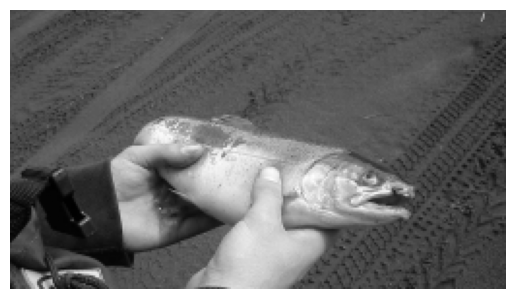

In [9]:
img = np.load('sensorium_data/static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6/data/images/0.npy')
plt.imshow(img.squeeze(), cmap='gray')
plt.axis('off')
img.shape

In [10]:
responses = np.load('sensorium_data/static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6/data/responses/0.npy')
responses.shape

(8372,)

The data contains gray scale images of size `144 x 256` and the corresponding responses of `8372` neurons in mouse primary visual cortex. For now, we'll ignore the behavior and the pupil and only use images and neuronal responses.

We can build a pytorch dataset for this data, using the the `FileTreeDataset` of `neuralpredictors`.

In [3]:
from neuralpredictors.data.datasets import FileTreeDataset

root_dir = 'sensorium_data/static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6'
dat = FileTreeDataset(root_dir, 'images', 'responses')
dat

FileTreeDataset /mnt/vast-react/home/sinz/u12034/jupyterhub-gwdg/Cajal 2025/sensorium_data/static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6 (n=5994 items)
	images, responses

Together with a sampler, we can create a pytorch dataloader

In [4]:

train_sampler = SubsetSampler(dat.trial_info.tiers == 'train', shuffle=True)
train_loader = DataLoader(dat, sampler=train_sampler, batch_size=64)


Now we can iterate through this data loader

In [21]:
for images, responses in train_loader:
    print(images.shape, responses.shape, type(images))
    print(f"Image mean+-std={images.mean()}+-{images.std()}") 
    print(f"Reponses mean+-std={responses.mean()}+-{responses.std()}") 
    break # let's stop after the first iteration

torch.Size([64, 1, 144, 256]) torch.Size([64, 8372]) <class 'torch.Tensor'>
Image mean+-std=110.56815338134766+-63.25040054321289
Reponses mean+-std=1.4050875902175903+-6.372110843658447


For our purpose here, the images are still a bit big (training time), so we let's downscale them by a factor of 4. In addition, let's standardize the pixel values and scale the neuronal responses to have std=1. We can do that with the help of a few functions in `neuralpredictors`.

In [7]:


root_dir = 'sensorium_data/static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6'
dat = FileTreeDataset(root_dir, 'images', 'responses')

transforms = [NeuroNormalizer(dat), ScaleInputs(scale=0.25), ToTensor(torch.cuda.is_available())]
dat.transforms.extend(transforms)


train_sampler = SubsetSampler(dat.trial_info.tiers == 'train', shuffle=True)
train_loader = DataLoader(dat, sampler=train_sampler, batch_size=64)


In [28]:
for images, responses in train_loader:
    print(images.shape, responses.shape, type(images))
    print(f"Image mean+-std={images.mean()}+-{images.std()}") 
    print(f"Reponses mean+-std={responses.mean()}+-{responses.std()}") 
    break # let's stop after the first iteration

torch.Size([64, 1, 36, 64]) torch.Size([64, 8372]) <class 'torch.Tensor'>
Image mean+-std=0.021316999569535255+-0.9531493782997131
Reponses mean+-std=0.3085346817970276+-0.9831728339195251


# Train our first model

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

root_dir = 'sensorium_data/static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6'
dat = FileTreeDataset(root_dir, 'images', 'responses')

transforms = [ScaleInputs(scale=0.125), ToTensor(torch.cuda.is_available())]
dat.transforms.extend(transforms)

train_sampler = SubsetSampler(dat.trial_info.tiers == 'train', shuffle=True)
test_sampler = SubsetSampler(dat.trial_info.tiers == 'test', shuffle=False)
val_sampler = SubsetSampler(dat.trial_info.tiers == 'validation', shuffle=False)

train_loader = DataLoader(dat, sampler=train_sampler, batch_size=64)
val_loader = DataLoader(dat, sampler=val_sampler, batch_size=64)
test_loader = DataLoader(dat, sampler=test_sampler, batch_size=64)

print(f"The training device is: {device}")

The training device is: cuda:0


<div class="task">

</div>

## First model

Now we are ready to build our first model. Please go through the tasks in order and see how/whether the performance of the model improves

1. Below you find a simple linear model. Write code to train the model on the training data.
    * What kind of loss could you use?
    * Monitor the performance (correlation) on the validation all 5 epochs (epoch=full sweep through the training data).
1. You'll find that the model is slow and does not train very well. Now try the following improvements and see how they increase the prediction performance.
    * Decrease the image resolution to `18 x 32`.
    * Add a `nn.BatchNorm1d` layer before the linear layer (make sure to put the model into `train` and `eval` mode respectively).
    * Add `weight_decay=1e-4` to the optimizer.
    * Add a rectifying nonlinearity `ReLU`, `Softplus` or `ELU + 1`.
    * Change the loss to `digital_twin_library.PoissonLoss`.
1. For the best model, produce plots that
    * compare the performance (correlation) between validation and train for all neurons.
    * plot linear filters (as grayscale images) of the best `n=12` neurons. What would you expect to see?
1. Think about the following questions
    * How many parameters does the model have?
    * Is there any benefit from having many neurons?
    * **Advanced**: The Poisson loss strictly a "correct" loss function?

In [83]:
class GLM(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten the images
        return self.linear(x)

In [55]:
set_background("#ffffd4")

class GLM(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.bn = nn.BatchNorm1d(input_dim)
        self.linear = nn.Linear(input_dim, output_dim)
        self.nonlinearity = nn.Softplus()
        
    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten the images
        return self.nonlinearity(self.linear(self.bn(x)))

model = GLM(18 * 32, 8372)
model = model.to(device)
model

# loss = nn.MSELoss() # mean squared error loss
loss  = PoissonLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=1e-4)

epochs = 50
for epoch in range(epochs):
    model.train()
    for images, responses in train_loader:
        optimizer.zero_grad()
        
        outputs = model(images)
        mse = loss(outputs, responses)
        mse.backward()
        optimizer.step()

    resp, pred = [], []
    
    if epoch % 5 == 0:
        # set the model in validation state
        resp, pred = [], []
        model.eval()
        for images, responses in train_loader:
            outputs = model(images)
            resp.append(responses.cpu().detach().numpy())
            pred.append(outputs.cpu().detach().numpy())
        resp = np.vstack(resp)
        pred = np.vstack(pred)
        train_corr = corr(resp, pred, dim=0)

        resp, pred = [], []
        
        # set the model in validation state
        model.eval()
        for images, responses in val_loader:
            outputs = model(images)
            resp.append(responses.cpu().detach().numpy())
            pred.append(outputs.cpu().detach().numpy())
        resp = np.vstack(resp)
        pred = np.vstack(pred)
        val_corr = corr(resp, pred, dim=0)
        print(f'Epoch [{epoch+1}/{epochs}], Validation correlation: {val_corr.mean():.4f}, Training correlation: {train_corr.mean():.4f}')

Epoch [1/50], Validation correlation: 0.0740, Training correlation: 0.0865
Epoch [6/50], Validation correlation: 0.0744, Training correlation: 0.0899
Epoch [11/50], Validation correlation: 0.0741, Training correlation: 0.0928
Epoch [16/50], Validation correlation: 0.0722, Training correlation: 0.0882
Epoch [21/50], Validation correlation: 0.0776, Training correlation: 0.0942
Epoch [26/50], Validation correlation: 0.0806, Training correlation: 0.0959
Epoch [31/50], Validation correlation: 0.0780, Training correlation: 0.0974
Epoch [36/50], Validation correlation: 0.0728, Training correlation: 0.0874
Epoch [41/50], Validation correlation: 0.0724, Training correlation: 0.0925
Epoch [46/50], Validation correlation: 0.0710, Training correlation: 0.0900


In [57]:
set_background("#ffffd4")

model.eval()
resp, pred = [], []

for images, responses in train_loader:
    outputs = model(images)
    resp.append(responses.cpu().detach().numpy())
    pred.append(outputs.cpu().detach().numpy())
resp = np.vstack(resp)
pred = np.vstack(pred)
train_corr = corr(resp, pred, dim=0)

resp, pred = [], []

for images, responses in val_loader:
    outputs = model(images)
    resp.append(responses.cpu().detach().numpy())
    pred.append(outputs.cpu().detach().numpy())
resp = np.vstack(resp)
pred = np.vstack(pred)
val_corr = corr(resp, pred, dim=0)

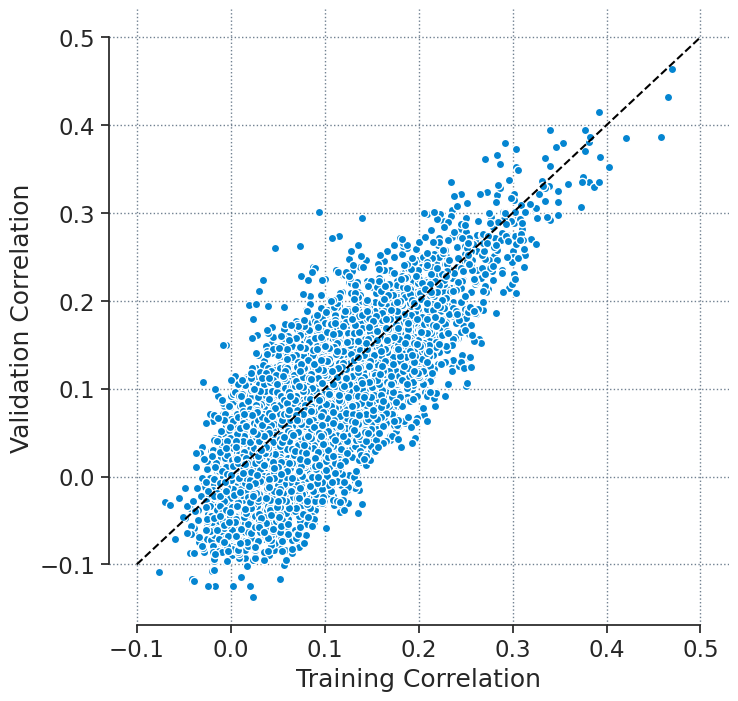

In [70]:
set_background("#ffffd4")

sns.set_context('notebook', font_scale=1.5)
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(train_corr, val_corr, 'ow', mfc=sns.xkcd_rgb['cerulean'])
ax.plot([-.1, .5], [-.1, .5], '--k')
ax.set(
    xlabel='Training Correlation', ylabel='Validation Correlation'
)
ax.grid(True, ls=':', color='slategray')
sns.despine(trim=True)


Best correlations [0.46385068 0.43203223 0.41528448 0.3946417  0.3942113  0.3869953
 0.38675728 0.38507098 0.38071877 0.38002425 0.37921435 0.3751017 ]


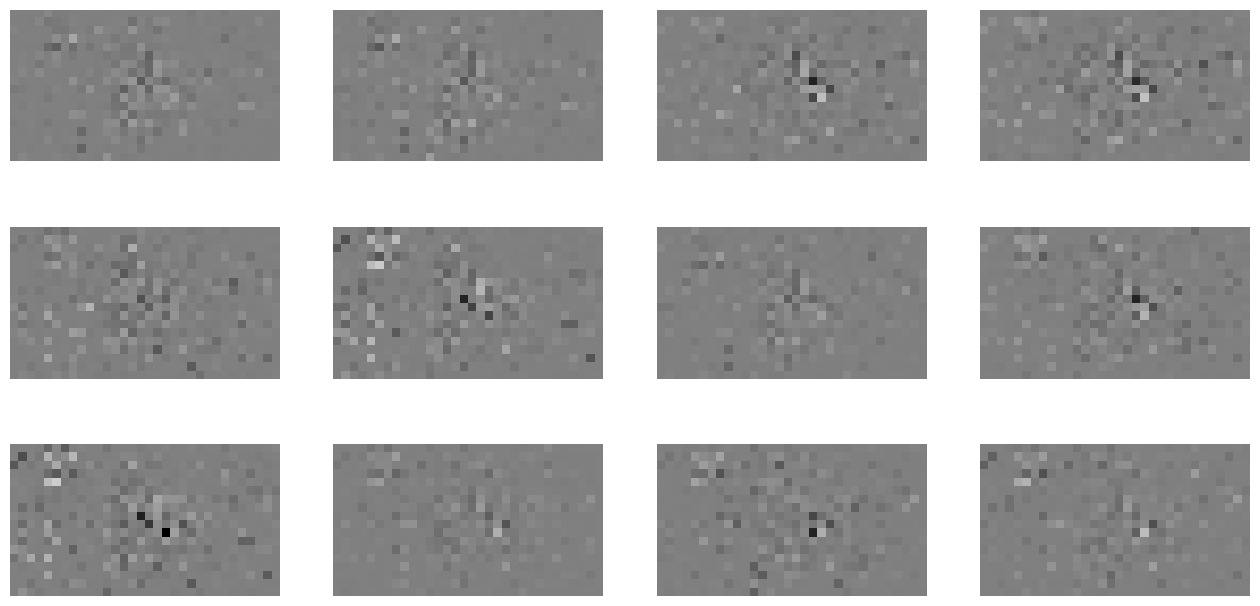

In [80]:
set_background("#ffffd4")

idx = np.argsort(-val_corr)
print(f"Best correlations {val_corr[idx[:12]]}")
W = model.linear.weight[idx[:12], :].detach().cpu().numpy()
wmax = np.abs(W).max()
with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(3, 4, figsize=(16, 8))
    for a, w in zip(ax.ravel(), W):
        a.imshow(w.reshape(18, 32), cmap='gray', vmin=-wmax, vmax=wmax)
        a.axis('off')

# Improving the model

Let's improve the model. First, let's use resolution `36 x 64` from now on. Also, let's standardize the images to `mean+-std=0+-1` and the neuronal responses to `std=1` (we keep them positive). 

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

root_dir = 'sensorium_data/static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6'
dat = FileTreeDataset(root_dir, 'images', 'responses')

transforms = [NeuroNormalizer(dat), ScaleInputs(scale=0.25), ToTensor(torch.cuda.is_available())]
dat.transforms.extend(transforms)

train_sampler = SubsetSampler(dat.trial_info.tiers == 'train', shuffle=True)
test_sampler = SubsetSampler(dat.trial_info.tiers == 'test', shuffle=False)
val_sampler = SubsetSampler(dat.trial_info.tiers == 'validation', shuffle=False)

train_loader = DataLoader(dat, sampler=train_sampler, batch_size=64)
val_loader = DataLoader(dat, sampler=val_sampler, batch_size=64)
test_loader = DataLoader(dat, sampler=test_sampler, batch_size=64)

print(f"The training device is: {device}")

The training device is: cuda:0


Let's now try to make our model better. You can try the following options

1. Make the model convolutional:
    * Instead of a linear layer, use a convolutional network with layers `(Conv2D, Batchnorm2D, Nonlinearity)`.
    * Use a final linear layer + rectifying nonlinearity to map the output of the network to the neurons.
    * A good start is 3 convolutional layers + final linear layer.
    * How many parameters does your model have? Is there a benefit of having many neurons now?
2. Reduce parameters
   * Replace the convolution by depthwise separable convolutions
   * Factorize the readout as in [Klindt et al. 2017](https://arxiv.org/abs/1711.02653).
   * **Advanced**: Implement a Gaussian Readout as in [Lurz et al. 2021](https://openreview.net/pdf?id=Tp7kI90Htd).
3. Improve the training routine
   * Use early stopping: Monitor the validation correlation. If it has not gone up for `patience` epochs, set the model to the best model so far and stop training.
   * Use learning rate schedules: Instead of stopping training, reduce the learning rate once or twice (e.g. with [ReduceLROnPlateau](https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html) ).

**Challenge**:
Let's make this a competition. Try to get the best model you can with the above (or other) tricks. We'll maintain a leader board at the front. Report your best validation correlation to us and we mark it down. Obviously, you're not allowed to train on the validation set. 

In [7]:
set_background("#ffffd4")

class DepthwiseSeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, 
                 padding=0, dilation=1, bias=True, padding_mode='zeros'):
        super(DepthwiseSeparableConv2d, self).__init__()
        
        # Depthwise convolution
        # groups=in_channels means each input channel gets its own filter
        self.depthwise = nn.Conv2d(
            in_channels=in_channels,
            out_channels=in_channels,  # Same number of output channels as input
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=in_channels,  # Key parameter for depthwise convolution
            bias=bias,
            padding_mode=padding_mode
        )
        
        # Pointwise convolution (1x1 conv)
        # Combines information across channels
        self.pointwise = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=bias
        )
    
    def forward(self, x):
        # Apply depthwise convolution first
        x = self.depthwise(x)
        # Then apply pointwise convolution
        x = self.pointwise(x)
        return x


class GaussianReadout(nn.Module):
    def __init__(self, output_dim, channels, spatial_scale, std_scale):
        super(GaussianReadout, self).__init__()
        self.pos_mean = nn.Parameter(torch.zeros(output_dim, 1, 2))
        self.pos_sqrt_cov = nn.Parameter(torch.zeros(output_dim, 2, 2))
        
        self.linear = nn.Parameter(torch.zeros(output_dim, channels))
        self.bias = nn.Parameter(torch.zeros(output_dim))
        
        self.pos_sqrt_cov.data.uniform_(-std_scale, std_scale)
        self.pos_mean.data.uniform_(-spatial_scale, spatial_scale)
        self.linear.data.fill_(1./channels)        
        
        
    def grid_positions(self, batch_size):
        if self.training:
            z = torch.randn(self.pos_mean.shape).to(self.pos_mean.device)
            grid = self.pos_mean + torch.einsum('nuk, njk->nuj', z, self.pos_sqrt_cov)
        else:
            grid = self.pos_mean
        grid = torch.clip(grid, -1, 1)
        return grid.expand(batch_size, -1, -1, -1) 
            
    def forward(self, x):
        batch_size = x.shape[0]
        grid = self.grid_positions(batch_size)
        
        # output will be batch_size x channels x neurons 
        x = torch.nn.functional.grid_sample(x, grid, align_corners=False).squeeze(-1)
        x = torch.einsum('bcn,nc->bn', x, self.linear) + self.bias.view(1, -1)
        return x
    
class ConvModel(nn.Module):
    def __init__(self, layers, input_kern, hidden_kern, hidden_channels, output_dim, spatial_scale = 0.1, std_scale = 0.5):
        super(ConvModel, self).__init__()
        
        self.conv_layers = nn.Sequential()
        core_layers = [nn.Conv2d(1, hidden_channels, input_kern), nn.BatchNorm2d(hidden_channels), nn.SiLU()]
        
        for _ in range(layers - 1):
            core_layers.extend([
                DepthwiseSeparableConv2d(hidden_channels, hidden_channels, hidden_kern),
                nn.BatchNorm2d(hidden_channels),
                nn.SiLU()
            ]
            )
        self.core = nn.Sequential(*core_layers)
        
        self.readout = GaussianReadout(output_dim, hidden_channels, spatial_scale=spatial_scale, std_scale=std_scale)
        
    def regularizer(self):
        return self.readout.linear.abs().mean()
        
    def forward(self, x):
        x = self.core(x)
        x = self.readout(x)
        
        return nn.functional.softplus(x)

In [8]:
set_background("#ffffd4")

from digital_twin_library import train_epoch, get_correlations

model_m = ConvModel(layers=3, input_kern=11, hidden_kern=5, hidden_channels=32, output_dim=8372)
model_m = model_m.to(device)
loss = PoissonLoss() # use different loss
optimizer = torch.optim.Adam(model_m.parameters(), lr=1e-3)

epochs = 50
for epoch in trange(epochs):
    model = train_epoch(model_m, train_loader, optimizer, loss)
    if epoch % 3 == 0:
        train_corrs = get_correlations(model_m, train_loader)
        val_corrs = get_correlations(model_m, val_loader)
        print(f'Epoch [{epoch+1}/{epochs}], Validation correlation: {val_corrs.mean():.4f}, Training correlation: {train_corrs.mean():.4f}')

/opt/conda/lib/python3.12/site-packages/neuralpredictors/measures/modules.py:80: UserWarning: Poissonloss is averaged per batch. It's recommended to use `sum` instead
  warnings.warn("Poissonloss is averaged per batch. It's recommended to use `sum` instead")


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Validation correlation: 0.0383, Training correlation: 0.0387
Epoch [4/50], Validation correlation: 0.0855, Training correlation: 0.0961
Epoch [7/50], Validation correlation: 0.1049, Training correlation: 0.1200
Epoch [10/50], Validation correlation: 0.1268, Training correlation: 0.1443
Epoch [13/50], Validation correlation: 0.1400, Training correlation: 0.1606
Epoch [16/50], Validation correlation: 0.1517, Training correlation: 0.1754
Epoch [19/50], Validation correlation: 0.1604, Training correlation: 0.1851
Epoch [22/50], Validation correlation: 0.1754, Training correlation: 0.2019
Epoch [25/50], Validation correlation: 0.1844, Training correlation: 0.2124
Epoch [28/50], Validation correlation: 0.1906, Training correlation: 0.2204
Epoch [31/50], Validation correlation: 0.1977, Training correlation: 0.2288
Epoch [34/50], Validation correlation: 0.2052, Training correlation: 0.2388
Epoch [37/50], Validation correlation: 0.2107, Training correlation: 0.2450
Epoch [40/50], 

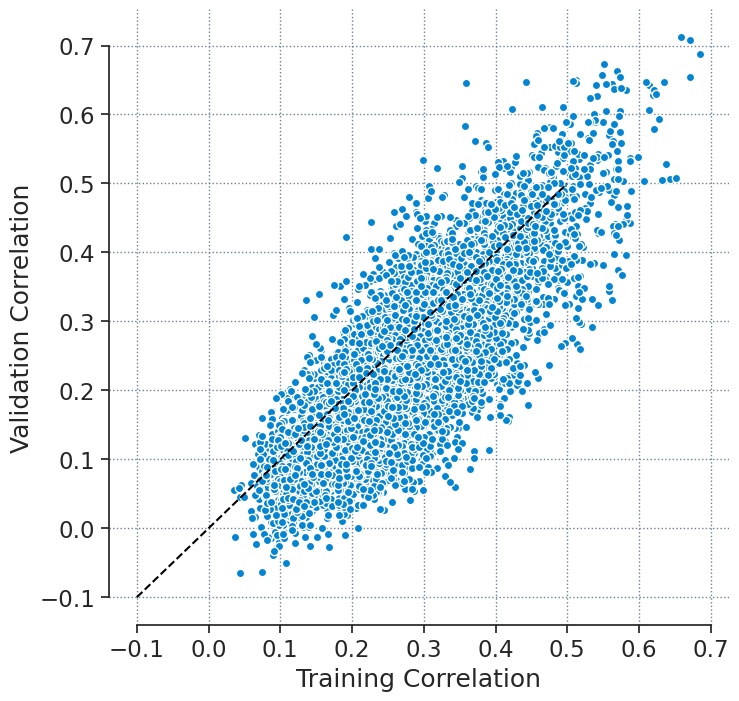

In [9]:
set_background("#ffffd4")

train_corrs = get_correlations(model_m, train_loader)
val_corrs = get_correlations(model_m, val_loader)


sns.set_context('notebook', font_scale=1.5)
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(train_corrs, val_corrs, 'ow', mfc=sns.xkcd_rgb['cerulean'], label='Convolutional Model')
ax.plot([-.1, .5], [-.1, .5], '--k')
ax.set(
    xlabel='Training Correlation', ylabel='Validation Correlation'
)
ax.grid(True, ls=':', color='slategray')
sns.despine(trim=True)


# Visualizing the results

Now that we have a well trained model, we can start analyzing it. However, unlike before, we cannot simply plot linear filters. However, we can run classical analyses (and more) on the model. In the following block we'll look at receptive fields. 

1. Run spike triggered averages on the model. I.e. present the model with Gaussian white noise (what previous modelling choice was important for that?) and record the responses. Then, for each if the best 12 neurons, compute the weighted mean of the noise frames using the predicted response of the neuron as weights. Plot the resulting images. What can you observe?

2. What happens if you do 1. with natural images. How can you explain the difference?

3. In stead of using STA, send the zero image through the model and compute the gradient with respect to the image. This can be done via

    ```python
    rfs = []
    for i in best[:12]:
        x = torch.zeros(1, 1, 36, 64).to(device)
        x.requires_grad = True
        r = model_m(x)
        r[0, i].backward()
        rfs.append(x.grad.cpu().numpy().squeeze())
    ```
    
    Plot the resulting images, too. What can you observe? Can you explain why you get this result?

In [10]:
set_background("#ffffd4")

with torch.no_grad():
    val_corrs = get_correlations(model_m, val_loader)
best = np.argsort(-val_corrs)

imgs, responses = [], []
idx = best[:12]
for _ in range(500):
    noise = torch.randn(100, 1, 36, 64).to(device)
    with torch.no_grad():
        resp = model_m(noise).cpu().numpy()[:, idx]
    responses.append(resp)
    imgs.append(noise.cpu().numpy())
imgs = np.concatenate(imgs, axis=0)
responses = np.concatenate(responses, axis=0)
responses = (responses - responses.mean(axis=0)) / responses.std(axis=0)


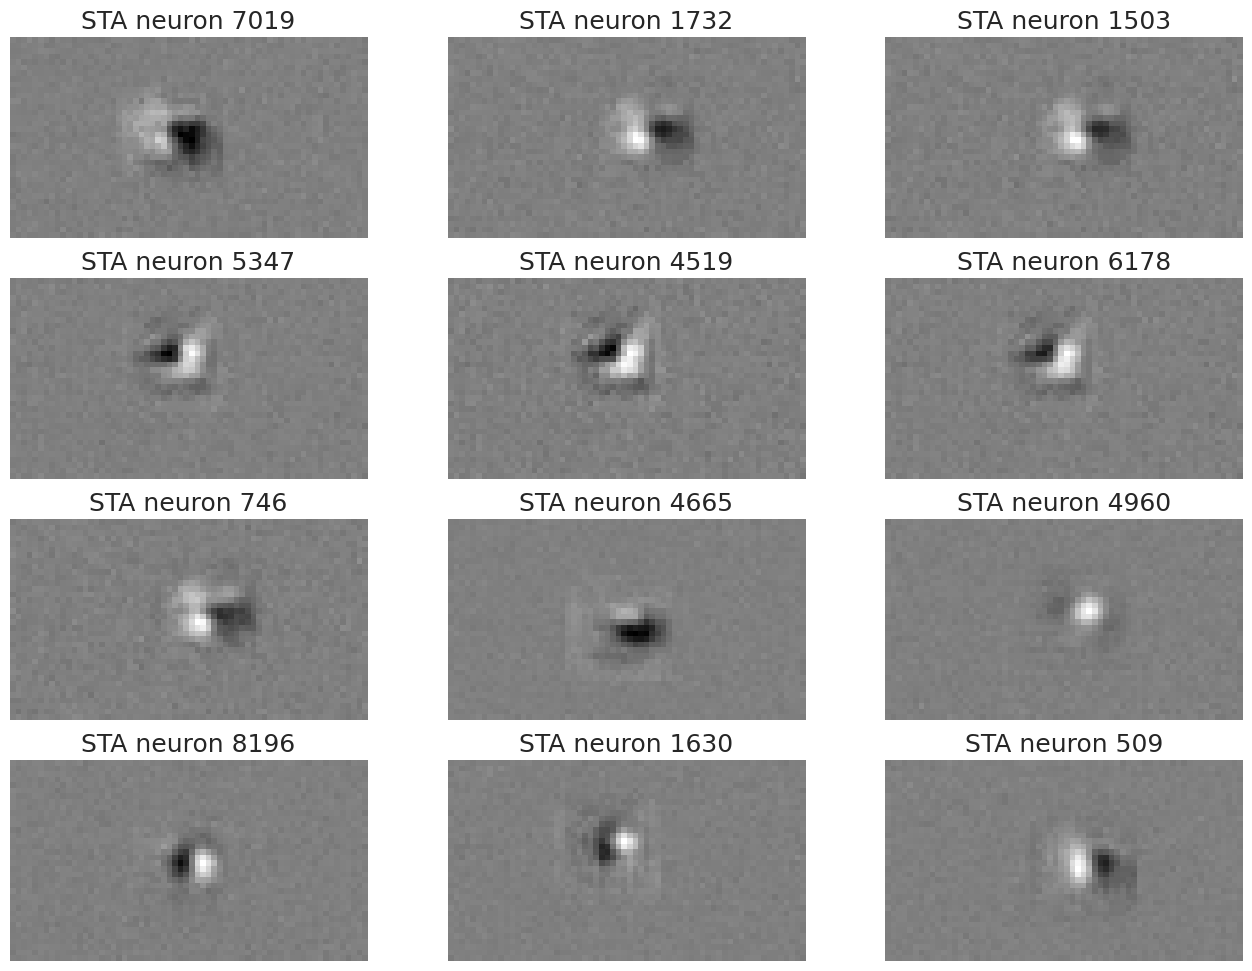

In [11]:
set_background("#ffffd4")

stas = (imgs * responses[..., None, None]).mean(axis=0)
with sns.axes_style('white'):
    fig, ax = plt.subplots(4, 3, figsize=(16, 12))
    for i, sta, a in zip(best, stas, ax.flatten()):
        vmax = np.abs(sta).max()
        a.imshow(sta.squeeze(), cmap='gray', vmin=-vmax, vmax=vmax)
        a.axis('off')
        a.set_title(f'STA neuron {i}')

In [12]:
set_background("#ffffd4")

rfs = []
for i in best[:12]:
    x = torch.zeros(1, 1, 36, 64).to(device)
    x.requires_grad = True
    r = model_m(x)
    r[0, i].backward()
    rfs.append(x.grad.cpu().numpy().squeeze())
    

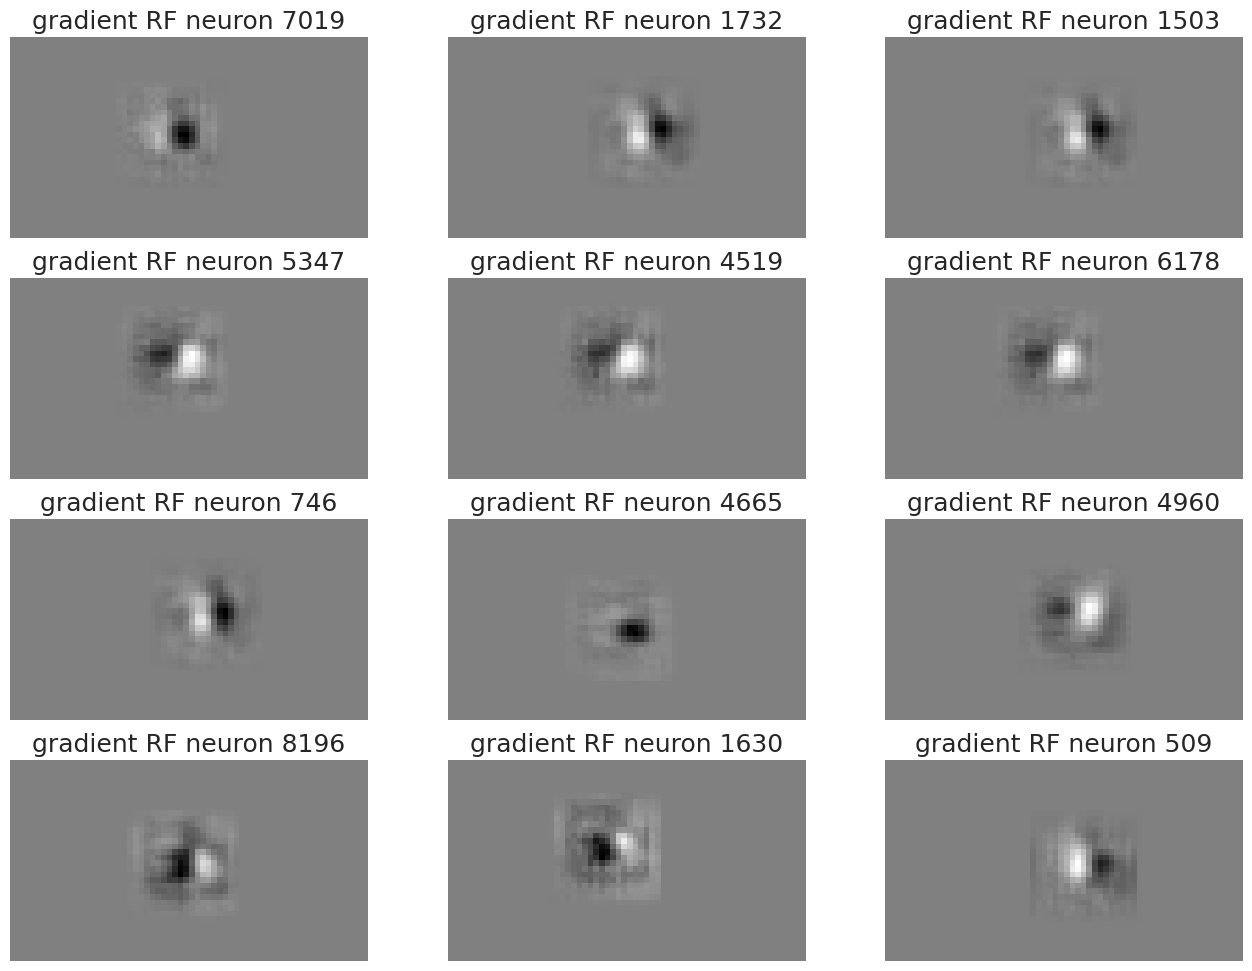

In [16]:
set_background("#ffffd4")

with sns.axes_style('white'):
    fig, ax = plt.subplots(4, 3, figsize=(16, 12))
    for i, rf, a in zip(range(len(rfs)), rfs, ax.flatten()):
        vmax = np.abs(rf).max()
        a.imshow(rf.squeeze(), cmap='gray',  vmin=-vmax, vmax=vmax)
        a.axis('off')
        a.set_title(f'gradient RF neuron {best[i]}')

# Optional: How good is good?

The best models so far, probably reached about `0.3` in correlation. Since correlation goes up until `1` this might not seem like a good result. However, neuronal responses are noisy. So even if we had the best predictor, we would not reach `1`. Thus, the question arises what's the best we could do. 

For many loss functions, the best predictor is the conditional mean, i.e. the average response to the same image over many repetitions. We can estimate this response from repeated presentations of the same stimulus. The dataset actually contains these kind of repetitions. However, for that we need a new sampler

In [29]:
 # this sampler groups all responses to the same image in one batch
from neuralpredictors.data.samplers import RepeatsBatchSampler


In [30]:
root_dir = 'sensorium_data/static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6'
dat = FileTreeDataset(root_dir, 'images', 'responses')

transforms = [NeuroNormalizer(dat), ScaleInputs(scale=0.25), ToTensor(torch.cuda.is_available())]
dat.transforms.extend(transforms)

test_sampler = RepeatsBatchSampler(dat.trial_info.frame_image_id, np.where(dat.trial_info.tiers == 'test')[0])

test_loader = DataLoader(dat, batch_sampler=test_sampler)

Test that you actually get the same image in each batch

In [31]:
set_background("#ffffd4")

for x, y in test_loader:
    print(x.shape, y.shape)
    x = x.detach().cpu().numpy()
    print(np.abs(np.diff(x, axis=0)).max())
    break

torch.Size([10, 1, 36, 64]) torch.Size([10, 8372])
0.0


Now use this dataset to compute an "oracle" predictor. Consider the response $y_{ij}$ of a neuron to the $i$th image shown the $j$th time. To compute the oracle predictor for this trial, we average all responses of that neuron to this image over all **but** the $j$th trial

$$\hat y_{ij} = \frac{1}{n-1} \sum_{k\not=j} y_{ik}$$

where $n$ is the number of repeats. Then use this predictor and correlate it with all $y_{ij}$ as if the oracle were model predictions. Compare that to the predictions of the model. 

In [32]:
set_background("#ffffd4")

responses, oracle_predictor = [], []
for _, y in test_loader:
    y = y.detach().cpu().numpy()
    responses.append(y)
    n = y.shape[0]
    trial_oracle = (n * np.mean(y, axis=0, keepdims=True) - y) / (n - 1)
    oracle_predictor.append(trial_oracle)
    
responses = np.vstack(responses)
oracle_predictor = np.vstack(oracle_predictor)

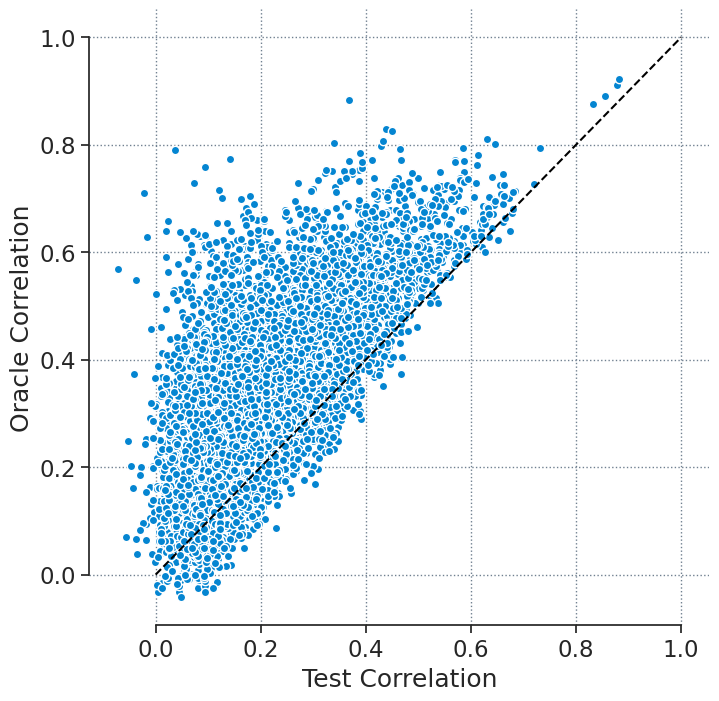

In [33]:
set_background("#ffffd4")

with torch.no_grad():
    test_corrs = get_correlations(model_m, test_loader)
oracle_correlation = corr(responses, oracle_predictor, dim=0)

sns.set_context('notebook', font_scale=1.5)
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(test_corrs, oracle_correlation, 'ow', mfc=sns.xkcd_rgb['cerulean'])
ax.plot([0, 1], [0, 1], '--k')
ax.set(
    xlabel='Test Correlation', ylabel='Oracle Correlation'
)
ax.grid(True, ls=':', color='slategray')
sns.despine(trim=True)
